(lines-database-doc)=
# Using the lines database

This guide walks through how to use and adjust the $\mathrm{LiMe}$ lines database to your observation properties.  

Let's start by loading a file from our [resources folder](https://github.com/Vital-Fernandez/lime/tree/master/examples/0_resources): 

In [1]:
from pathlib import Path
import lime

data_folder = Path('../0_resources/spectra')
output_folder = Path('../0_resources/results')
file_address = data_folder/'SHOC579_MANGA38-35.txt'

spec = lime.Spectrum.from_file(file_address, instrument='text', redshift=0.0475)

/home/vital/anaconda3/envs/lime2/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/vital/anaconda3/envs/lime2/lib/python3.12/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In this object, we have a $[FeIII]4658\AA$ line with an P Cygni profile. If we fit it, $\mathrm{LiMe}$ will use its lines database the get its transition wavelength and bands, as well as the default, the default emission, Gaussian profile will be used:

In [2]:
# Line data
print(lime.lineDB.frame.loc['Fe3_4658A'])
print(f'\nDatabase default shape {lime.lineDB.get_shape()}, profile {lime.lineDB.get_profile()} and units {lime.lineDB.get_units()}')

wavelength                       4658.09
wave_vac                         4659.47
w1                           4637.507567
w2                           4650.238986
w3                           4651.874914
w4                           4664.305086
w5                           4669.709024
w6                            4679.09797
latex_label    $[FeIII]4658\mathring{A}$
units_wave                      Angstrom
particle                             Fe3
trans                                col
rel_int                                1
Name: Fe3_4658A, dtype: object

Database default shape emi, profile g and units Angstrom


Hence, if we fit the line, it will result in an Emission shape with a Gaussian profile:

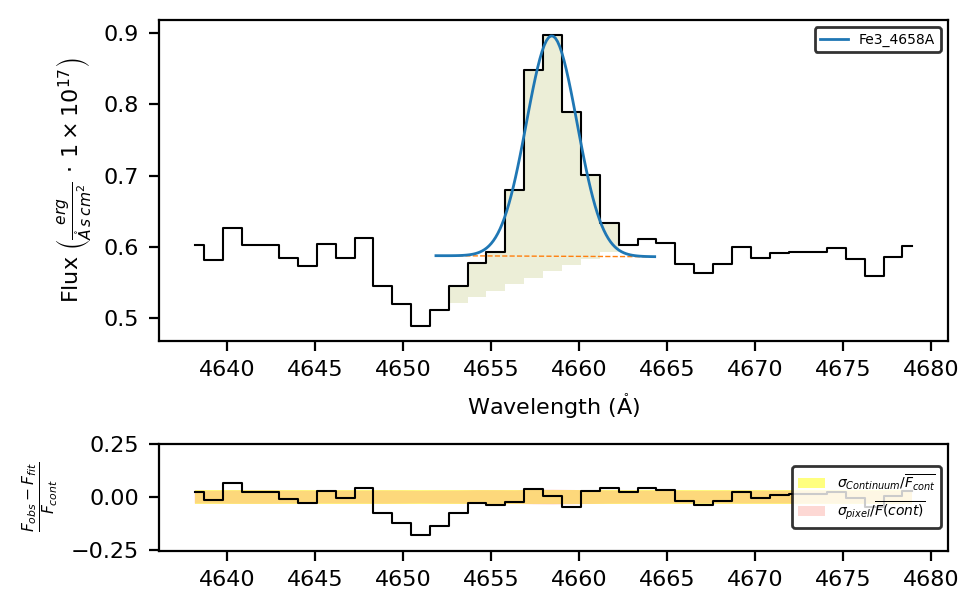

In [3]:
spec.fit.bands('Fe3_4658A', cont_source=True)
spec.plot.bands(rest_frame=True, show_continua=False)

To fit an absorption, we need to set the ``shape='abs'`` attribute. Moreover, since the line centroid is displaced from the theoretical transition wavelength, we are going to change the default value to improve the fitting.

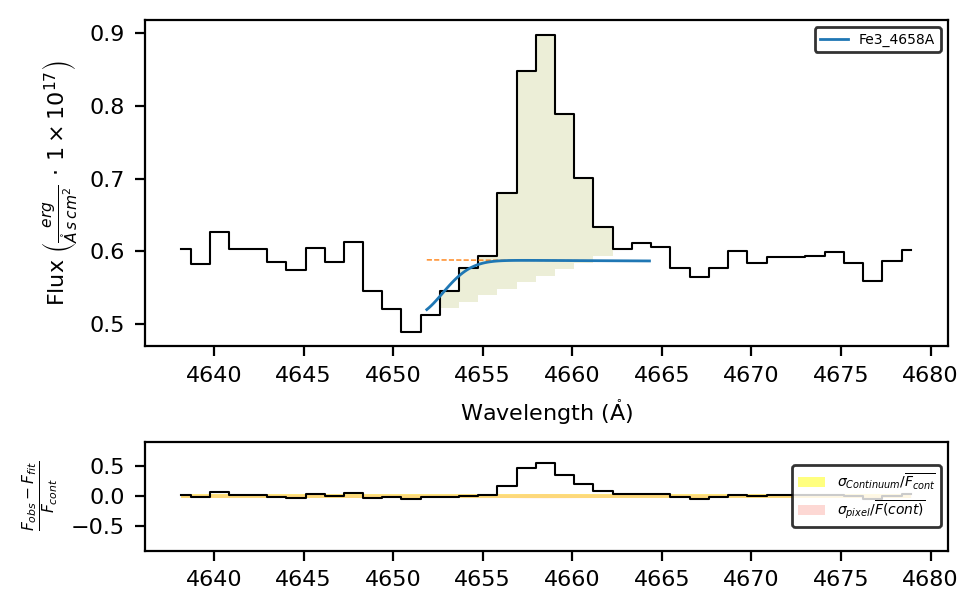

In [4]:
spec.fit.bands('Fe3_4658A', shape='abs', fit_cfg={'Fe3_4658A_center': {'value':4651.0}}, cont_source=True)
spec.plot.bands(rest_frame=True, show_continua=False)

This is, however, a poor fit because the band does not cover the absorption region. In most cases, it is better to have a lines table tailored to your observation.

## Retrieving an object lines table:

Let's start by deleting the previous measurements and converting the spectrum units

In [5]:
# Delete the line measurements
spec.clear_data()

# Convert the spectrum axis units
spec.unit_conversion(wave_units_out='nm')

LiMe INFO: The observation does not include a normalization but the mean flux value is below 0.001. The flux will be automatically normalized by 1e-19.


If you use the ``.retrieve.lines_frame`` you obtain a lines table matching the observation wavelength range, its redshift, and its units.

          wavelength          w3          w4      latex_label
H1_3704A    370.3794  369.246156  371.512644      $HI370.4nm$
S3_3722A    372.1570  371.018317  373.295683  $[SIII]372.2nm$
O2_3726A    372.5974  371.457369  373.737431   $[OII]372.6nm$
O2_3729A    372.8756  371.734718  374.016482   $[OII]372.9nm$
H1_3750A    375.0092  373.861790  376.156610        $HI375nm$
...              ...         ...         ...              ...
H1_9015A    901.4774  898.719163  904.235637      $HI901.5nm$
S3_9068A    906.8500  904.075325  909.624675  $[SIII]906.8nm$
H1_9229A    922.8875  920.063755  925.711245      $HI922.9nm$
S3_9530A    953.0400  950.123998  955.956002    $[SIII]953nm$
H1_9546A    954.5830  951.662277  957.503723      $HI954.6nm$

[72 rows x 4 columns]


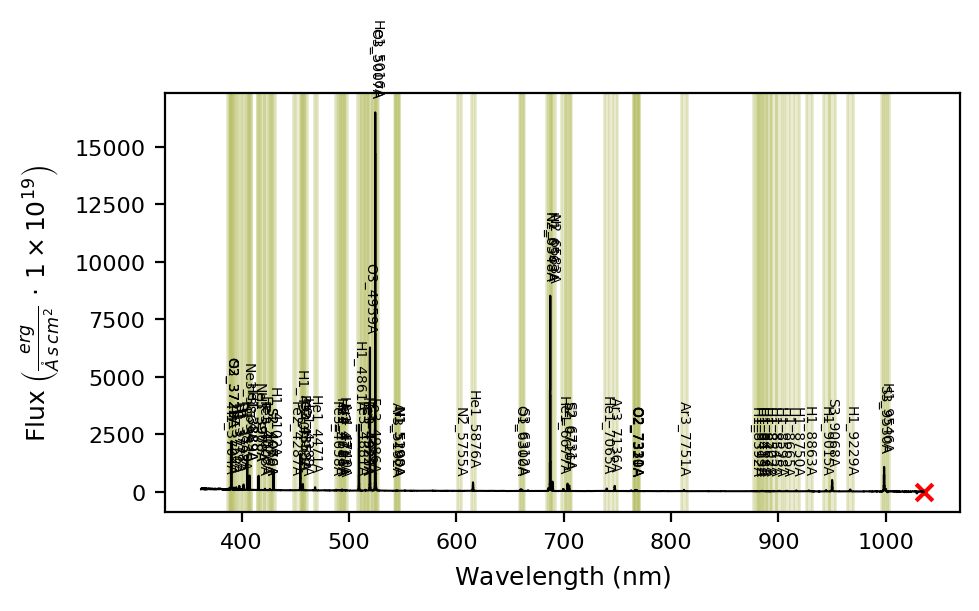

In [6]:
bands_um = spec.retrieve.lines_frame(band_vsigma=200, update_latex=True)
print(bands_um[['wavelength', 'w3', 'w4', 'latex_label']])
spec.plot.spectrum(bands=bands_um)

<div class="alert alert-success">

**Please note:** with the ``update_labels=True`` you can also change the format of the labels: **H1_3704A** → **H1_370.4nm**

</div>

If we repeat the absorption fit, we just need to change the initial value to match the new units:

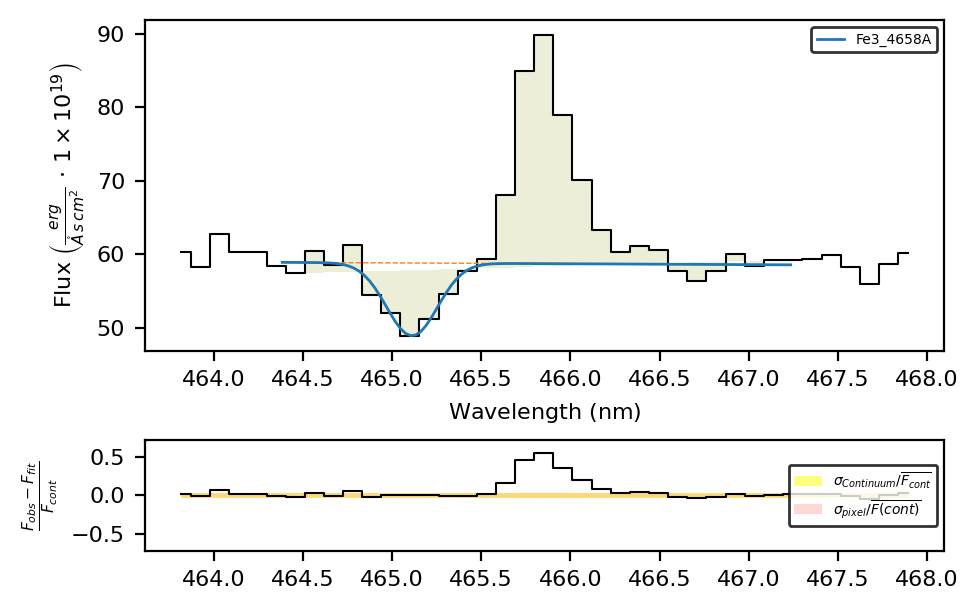

In [7]:
spec.fit.bands('Fe3_4658A', bands_um, shape='abs', fit_cfg={'Fe3_4658A_center': {'value':465.1}}, cont_source=True)
spec.plot.bands(rest_frame=True, show_continua=False)

## Profile and shape attributes in a lines table

If your observation contains lines with different shapes and profiles, it is more practical to specify these attributes in the input lines table. Let’s start by resetting the lines database and the spectrum units

In [8]:
# Reseting default object units
lime.lineDB.reset()
spec.clear_data()
spec.unit_conversion(wave_units_out='AA')

LiMe INFO: The observation does not include a normalization but the mean flux value is below 0.001. The flux will be automatically normalized by 1e-19.


Since the lines frame is a pandas dataframe, you can simply add the columns with a default value:

In [9]:
bands_obj = spec.retrieve.lines_frame(band_vsigma=200)
bands_obj[['shape', 'profile']] = 'emi', 'g'

And then update specific lines:

In [10]:
bands_obj.loc['Fe3_4658A', 'wavelength'] = 4651.0
bands_obj.loc['Fe3_4658A', 'shape'] = 'abs'
bands_obj.loc['H1_4861A', 'profile'] = 'l'

For example, now $H\beta$ has a Lorentz profile:

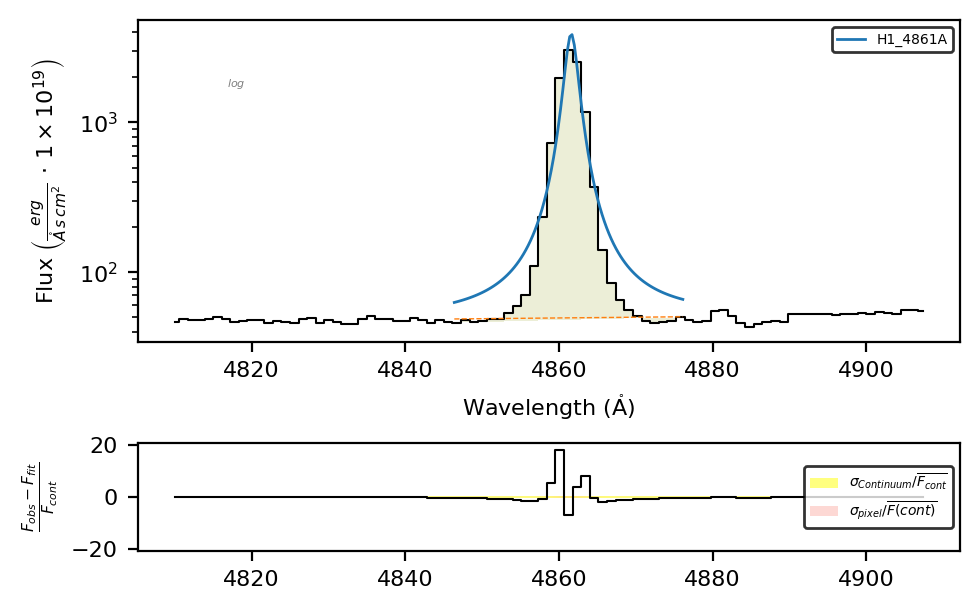

In [11]:
spec.fit.bands('H1_4861A', bands_obj, cont_source=True)
spec.plot.bands(show_continua=False, rest_frame=True)

And if we fit the If we fit the $[FeIII]4658\AA$ absorption, we don't need to include the ``shape`` or the *wavelength* initial value because this information is provided by the input table:

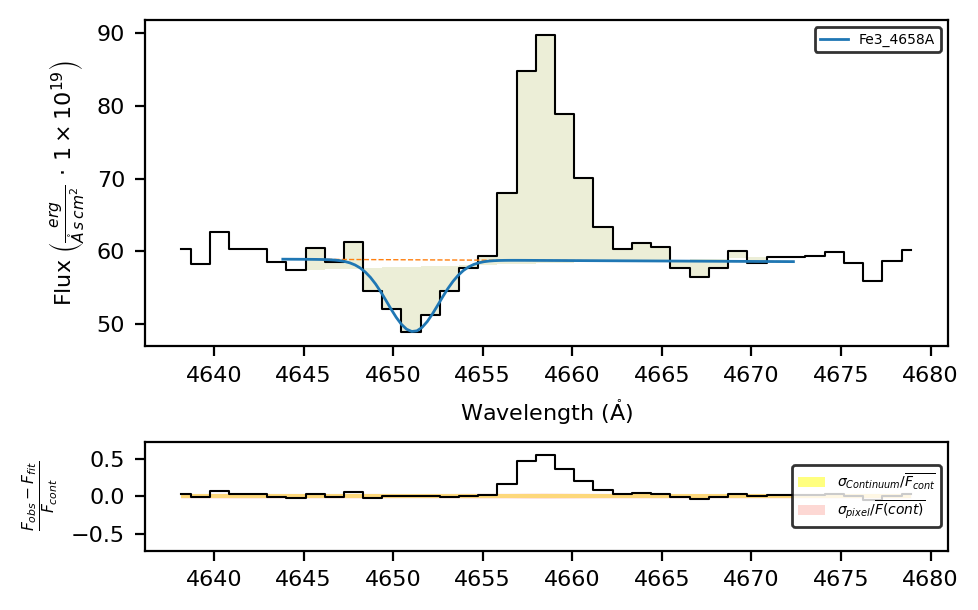

In [12]:
spec.fit.bands('Fe3_4658A', bands_obj, cont_source=True)
spec.plot.bands(show_continua=False, rest_frame=True)

However, if we try to fit the emission:

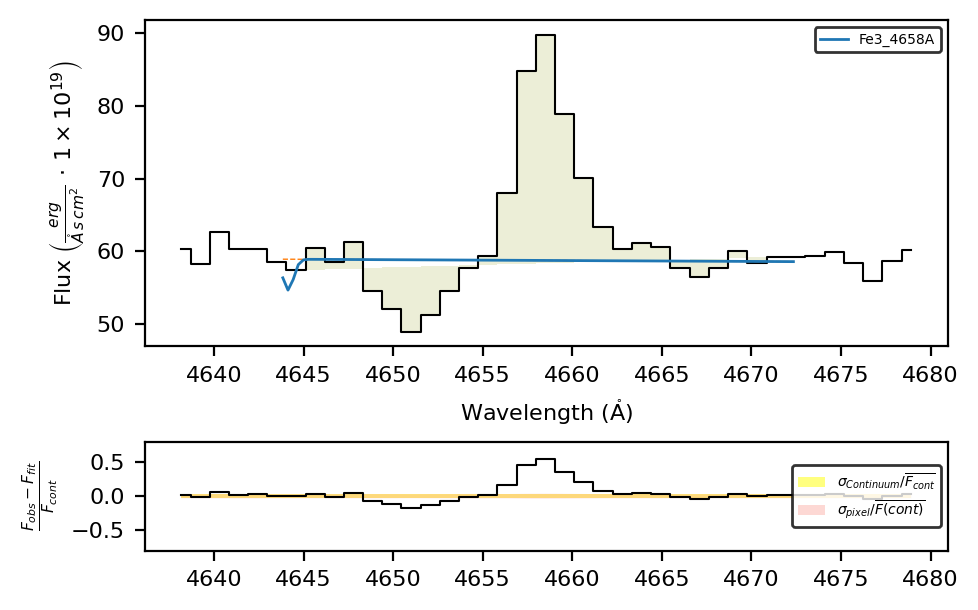

In [13]:
spec.fit.bands('Fe3_4658A', bands_obj, shape='emi', fit_cfg={'Fe3_4658A_center': {'value': 4658}}, cont_source=True)
spec.plot.bands(show_continua=False, rest_frame=True)

The fitting fails because the ``bands_obj`` properties overwrites the ``shape/profile`` attributes. 

In order to overwrite ``profile`` and ``shape`` columns values from the user (or default) table, you have two options:

a) Use the line label suffixes:

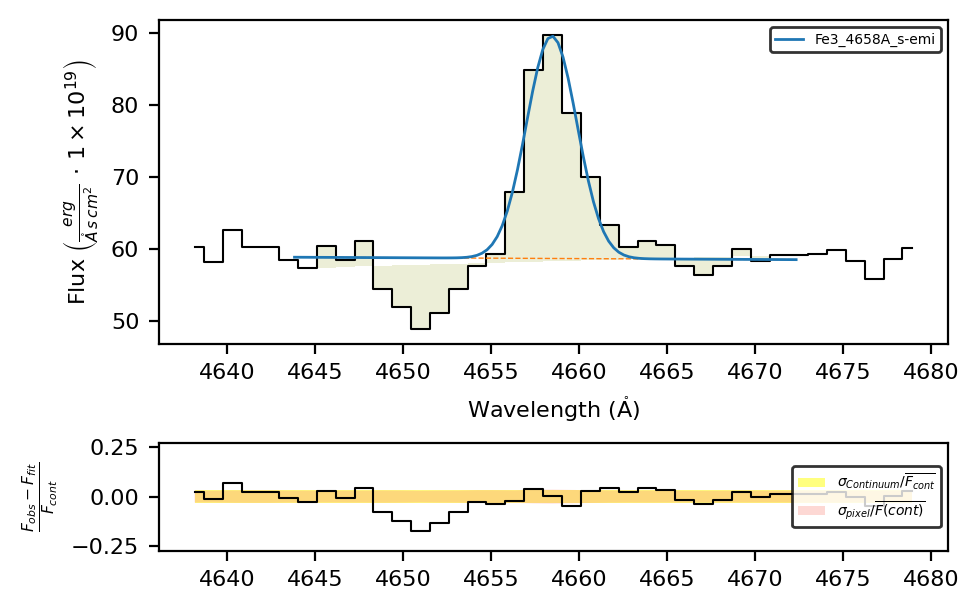

In [14]:
spec.fit.bands('Fe3_4658A_s-emi', bands_obj, fit_cfg={'Fe3_4658A_s-emi_center': {'value': 4658}}, cont_source=True)
spec.plot.bands(show_continua=False, rest_frame=True)

b) Use the fitting configuration:

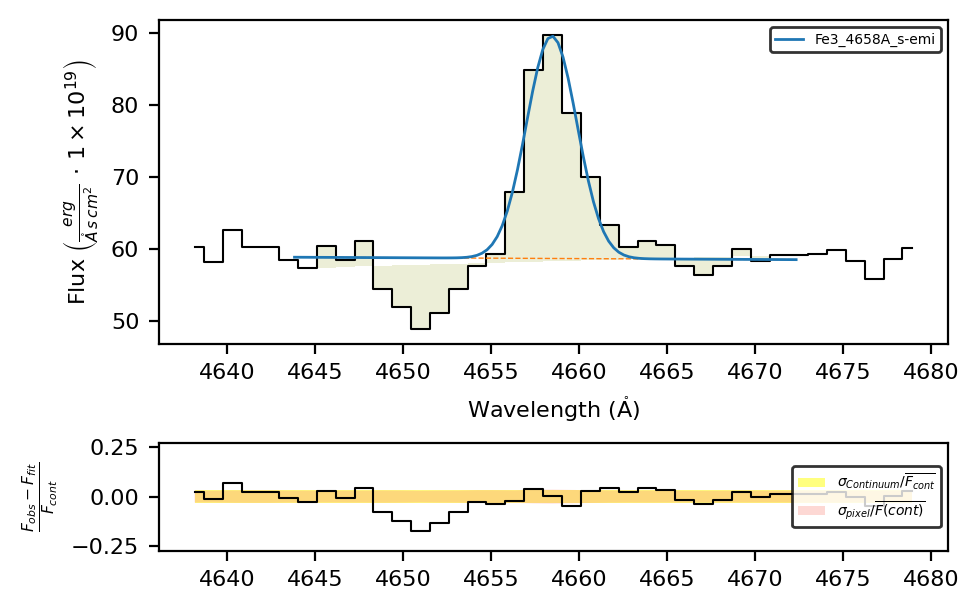

In [15]:
fit_cfg = {'transitions': {"Fe3_4658A": {"wavelength": 4658,
                                         "shape": "emi"}}}

spec.fit.bands('Fe3_4658A', bands_obj, fit_cfg=fit_cfg, cont_source=True)
spec.plot.bands(show_continua=False, rest_frame=True)

## Mixing lines parameters from tables and configuration files.


If you are using a lines table for an large set of objects, and you just need to adjust it to certain cases, you can use the configuration file. 

For example, to fit both components (note that now the default shape is absorption), we can write:

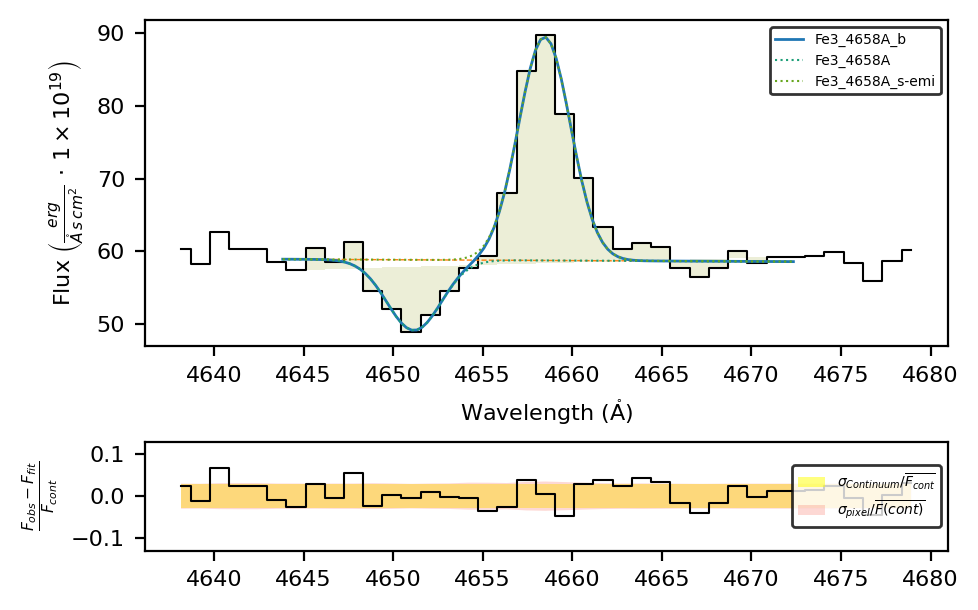

In [16]:
fit_cfg =  {"Fe3_4658A_b"   : 'Fe3_4658A+Fe3_4658A_s-emi',
            'transitions'   : {"Fe3_4658A_s-emi"    : {"wavelength": 4658, "shape": "emi"}}
            }


spec.fit.bands('Fe3_4658A_b', bands_obj, fit_cfg=fit_cfg, cont_source=True)
spec.plot.bands(show_continua=False, rest_frame=True)

## Change the default line database

The ``lime.lines_frame`` provides a convenience function to generate a copy of the lines database: 

In [17]:
lime.lineDB.reset()
spec.clear_data()
spec.unit_conversion(wave_units_out='nm')
lines_db_nm = lime.lines_frame(units_wave='nm', update_latex=True, update_labels=True)
lime.save_frame(output_folder/'lines_db_nm.txt', lines_db_nm)

LiMe INFO: The observation does not include a normalization but the mean flux value is below 0.001. The flux will be automatically normalized by 1e-19.


This can be used to overwrite the lines database on a per-script basis:

In [18]:
lime.lineDB.reset(frame_address=output_folder/'lines_db_nm.txt', default_profile='l', default_shape='emi')
print(lime.lineDB.frame[['wavelength', 'units_wave', 'latex_label']])

                 wavelength units_wave      latex_label
H1_121.6nm       121.567000         nm      $HI121.6nm$
O4_140.1nm       140.116400         nm    $OIV]140.1nm$
O4_140.5nm       140.481300         nm    $OIV]140.5nm$
O4_140.7nm       140.738900         nm    $OIV]140.7nm$
N4_148.3nm       148.332100         nm   $[NIV]148.3nm$
...                     ...        ...              ...
H2-S1_17030nm  17034.845756         nm   $H2-SI17030nm$
S3_18710nm     18713.030000         nm  $[SIII]18710nm$
Ne5_24320nm    24317.500000         nm   $[NeV]24320nm$
O4_22580nm     22580.000000         nm   $[OIV]22580nm$
H2-S0_28220nm  28218.843793         nm    $H2-S28220nm$

[151 rows x 3 columns]


Now, the wavelength values are in nm and the the profiles are Lorentzian

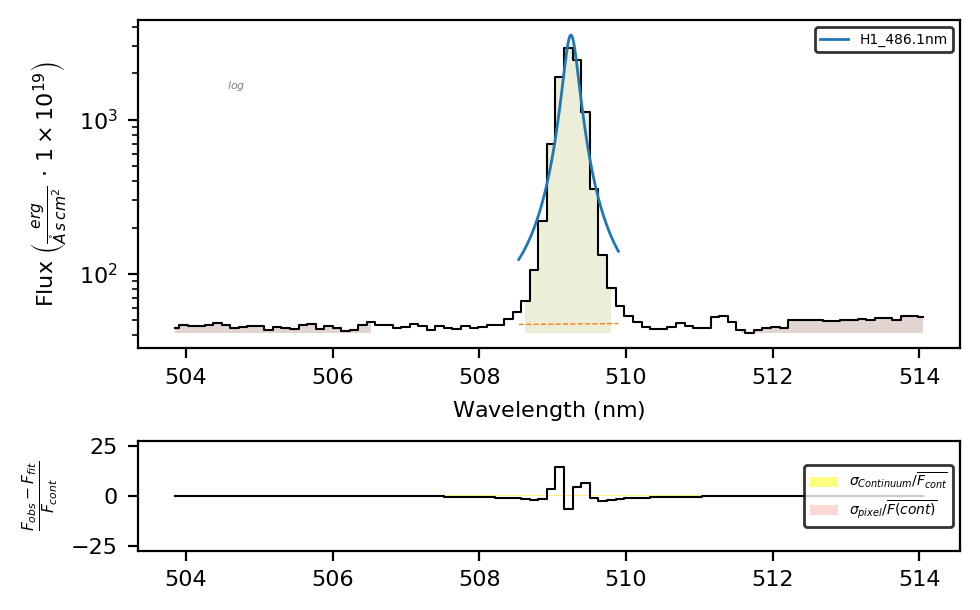

In [22]:
spec.fit.bands('H1_486.1nm')
spec.plot.bands()

Finally, in order to change the lines database permanently, you can find it at this location:

In [20]:
lime_database_address = lime.transitions._DATABASE_FILE

## Takeaways

- $\mathrm{LiMe}$ uses a tabulated lines database to obtain transition wavelengths from [the default lines database](../1_introduction/2_line_labels.ipynb).
- By default, lines are fitted with a Gaussian emission profile. There are several ways to change these default values depending on your data:
  - For small samples with few lines, you can use the ``shape``/``profile`` function arguments and/or the [line notation profile/shape suffixes](../1_introduction/2_line_labels.ipynb).
  - For large groups of spectra (e.g., spatial regions in IFU datasets), you can use line frames.
  - For large sets of different spectra, you can combine line frames with fitting configurations for individual objects.
- You can access a copy of the default lines database using ``lime.lines_frame``, or generate one tailored to your observation using ``Spectrum.retrieve.lines_frame``.
- The lines database is managed by the ``lime.lineDB`` variable, which can be modified on a per-script basis.
- The default lines database can be permanently modified by editing the text file at ``lime.transitions._DATABASE_FILE``.